<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/Staging-Notebooks/How_to_quickly_compare_cohorts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   How to quickly compare cohorts
Author:  Lauren Hagen
Created: 2020-04-09
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_quickly_compare_cohorts.ipython
Purpose: Compare cohorts with survival curve and histograms creating the cohort with data from BigQuery or the WebApp
Notes: 
```
***

# Overview

In this notebook, we will compare two cohorts with survival curves and feature comparisons. We will be using data from the [Lung Adenocarcinoma](https://portal.gdc.cancer.gov/projects/TCGA-LUAD) (LUAD) and [Lung Squamous Cell Carcinoma](https://portal.gdc.cancer.gov/projects/TCGA-LUSC) (LUSC) projects from the TCGA program.

This notebook can handle multiple or different cohorts from the TCGA program. The 'Load Cohort' code block can be updated to add or change the cohorts.

# Authorization, install or load packages, and create client

Before we get started, we will need to load the BigQuery module, authenticate ourselves, create a client variable, and import and load necessary libraries.

In [1]:
# Load the BigQuery Module
from google.cloud import bigquery

from google.colab import auth
try:
  auth.authenticate_user()
  print('You have been successfully authenticated!')
except:
  print('You have not been authenticated.')

You have been successfully authenticated!


In [2]:
# Create a variable for which client to use with BigQuery
project_num = 'your_project_number' # Replace with your project ID
if project_num == 'your_project_number':
  print('Please update the project number with your Google Cloud Project')
else:
  client = bigquery.Client(project_num)
  print('Client Variable Created')

Client Variable Created


In [3]:
# Install the lifelines package, if necessary
!pip install lifelines -q

     |████████████████████████████████| 348kB 2.6MB/s 


In [4]:
# Import libraries
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
import matplotlib.pyplot as plt
import pandas as pd

# Load Cohort
First we will need to load our cohort into a data frame. The cohort can either be made using the WebApp or a SQL query to the TCGA clinical tables. A cohort is a list of case barcodes from the TCGA program. The first code block can be updated to include 2 or more cohorts. We are going to use the sample queries filled in below as an example.

In [5]:
# Load Cohort
# Update this code bolck with your cohorts
# Fill in how the cohort will be created
# SQL or File
cohort_type = "SQL"

# Load a list of case_barocodes from our WebApp

file1 = 'your_first_file_location_here' # update with your file location, if using one
# Or insert a SQL query
query1 = """
  SELECT
    case_barcode
  FROM
   `isb-cgc.TCGA_bioclin_v0.Clinical`
  WHERE
    disease_code = 'LUAD'
  """
file2 = 'your_second_file_location_here' # update with your file location, if using one
# Or insert a SQL query
query2 = """
  SELECT
    case_barcode
  FROM
   `isb-cgc.TCGA_bioclin_v0.Clinical`
  WHERE
    disease_code = 'LUSC'
  """

# Update with files or queries used
cohort = {"Cohort_1": query1, "Cohort_2": query2}

In [6]:
# Function to create a combined labled list of cohorts for comparison
def load_cohort(cohorts, cohort_type):
  final_list = pd.DataFrame()

  for cohort in cohorts.keys():
    if cohort_type == 'SQL':
      cohort_query_request = client.query(cohorts.get(cohort))
      barcodes = cohort_query_request.result().to_dataframe()
    else:
      cohort_raw = pd.read_csv(cohorts.get(cohort), header=1)
      barcodes = pd.DataFrame({'case_barcode': cohort_raw['Case Barcode']})
    barcodes['cohort'] = cohort
    final_list = pd.concat([final_list, barcodes])
  return final_list

In [7]:
combined_list = load_cohort(cohort, cohort_type)

# Survival Curve
First, we will compare groups with a survival curve. We will be using a Kaplan Meier Curve from the [`lifelines` package](lifelines.readthedocs.io).


In [8]:
# Pull the vital status, days to death, and grouping column
# into a data frame
sc_query = """
SELECT
  case_barcode,
  vital_status,
  days_to_death
FROM
  `isb-cgc.TCGA_bioclin_v0.Clinical`
WHERE
  case_barcode IN ('{}') AND
  vital_status IS NOT NULL
""".format("','".join(combined_list['case_barcode']))
sc_query_request = client.query(sc_query)
survival_curve = pd.merge(sc_query_request.result().to_dataframe(),
                          combined_list, how="inner", on="case_barcode")

# Fill in NAs in days_to_death with the max from the days to death
T = survival_curve['days_to_death'].fillna(survival_curve['days_to_death'].max())
# Convert the vital status to numbers
E = survival_curve['vital_status'].replace({'Alive':0, 'Dead':1})

Text(0.5, 0, 'Days')

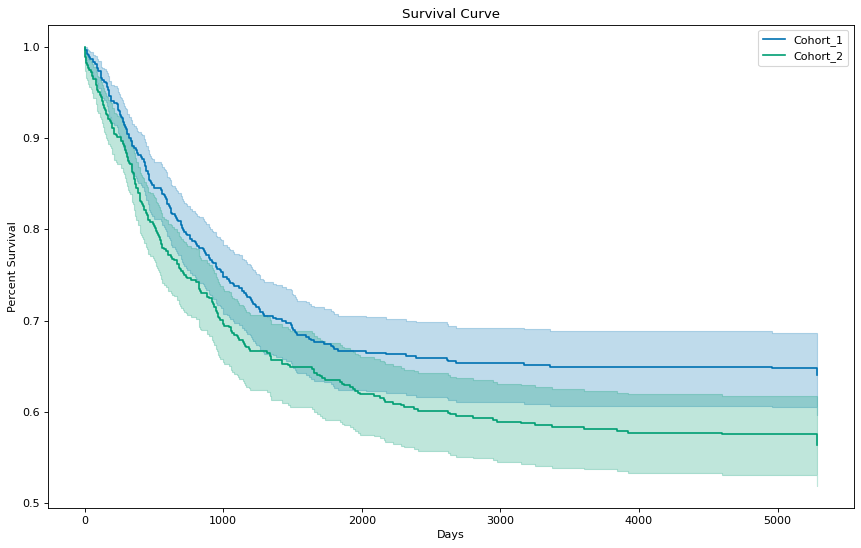

In [9]:
# Plot the survivial curve
fig=plt.figure(figsize=(13, 8), dpi= 80)
plt.style.use('seaborn-colorblind')
ax = plt.subplot(111,
                 title = "Survival Curve")

for r in survival_curve['cohort'].sort_values().unique():
  if (r != None):
    cohort = survival_curve['cohort'] == r
    kmf.fit(T.loc[cohort], E.loc[cohort], label=r)
    kmf.plot(ax=ax, )
  else:
    print("")

ax.set_ylabel("Percent Survival")
ax.set_xlabel("Days")

# if you would like to save this plot as an image, uncomment the next two lines
# survival_curve_file = "file_name_here.png"
# plt.savefig(survival_curve_file)

## Survival Curve Summary

We now have our two cohorts plotted with a survival curve. We can see that the percent survival falls faster for Cohort 2 (LUSC) than Cohort 1 (LUAD). Below is a section on compare the case counts for different features within the data.

Listed below are some useful resources on Survival Curves:
- [Kaplan-Meier Estimator Wikipedia](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator)
- []()

# Feature Comparisons

We may also like to view the distribution of the patient's ages, gender, and vital status between the two data sets. We can do this by creating bar charts for each feature.

First, we will get the data from BigQuery for the desired features.

In [29]:
# Create a query to retrieve the cohort features
hist_query = """
SELECT
  case_barcode,
  gender,
  vital_status,
  age_at_diagnosis,
  ethnicity,
  pathologic_stage
FROM
  `isb-cgc.TCGA_bioclin_v0.Clinical`
WHERE
  case_barcode IN ('{}')
""".format("', '".join(combined_list['case_barcode']))
hist_query_request = client.query(hist_query)
compare = hist_query_request.result().to_dataframe()
compare = pd.merge(compare, combined_list, how="inner", on="case_barcode")

Next we will want to view if there are any missing values in our cohorts.

In [30]:
# View the number of missing records in the data set
compare.isna().sum()

case_barcode          0
gender               63
vital_status         63
age_at_diagnosis     91
ethnicity           366
pathologic_stage     75
cohort                0
dtype: int64

Then we will need to transform the data a little bit, so that we are able to make the categorical histogram.

In [31]:
comp_gender = pd.DataFrame()
comp_vital_status = pd.DataFrame()
comp_ethnicity = pd.DataFrame()
comp_pathologic_stage = pd.DataFrame()

for i in compare['cohort'].sort_values().unique():
  df = compare['cohort'] == i
  comp_gender[i] = compare['gender'].loc[df].value_counts()
  comp_vital_status[i] = compare['vital_status'].loc[df].value_counts()
  comp_pathologic_stage[i] = compare['pathologic_stage'].loc[df].value_counts()
  comp_ethnicity[i] = compare['ethnicity'].loc[df].value_counts()

Finally, we will plot the features on bar charts.


Text(0.5, 0, 'pathologic_stage')

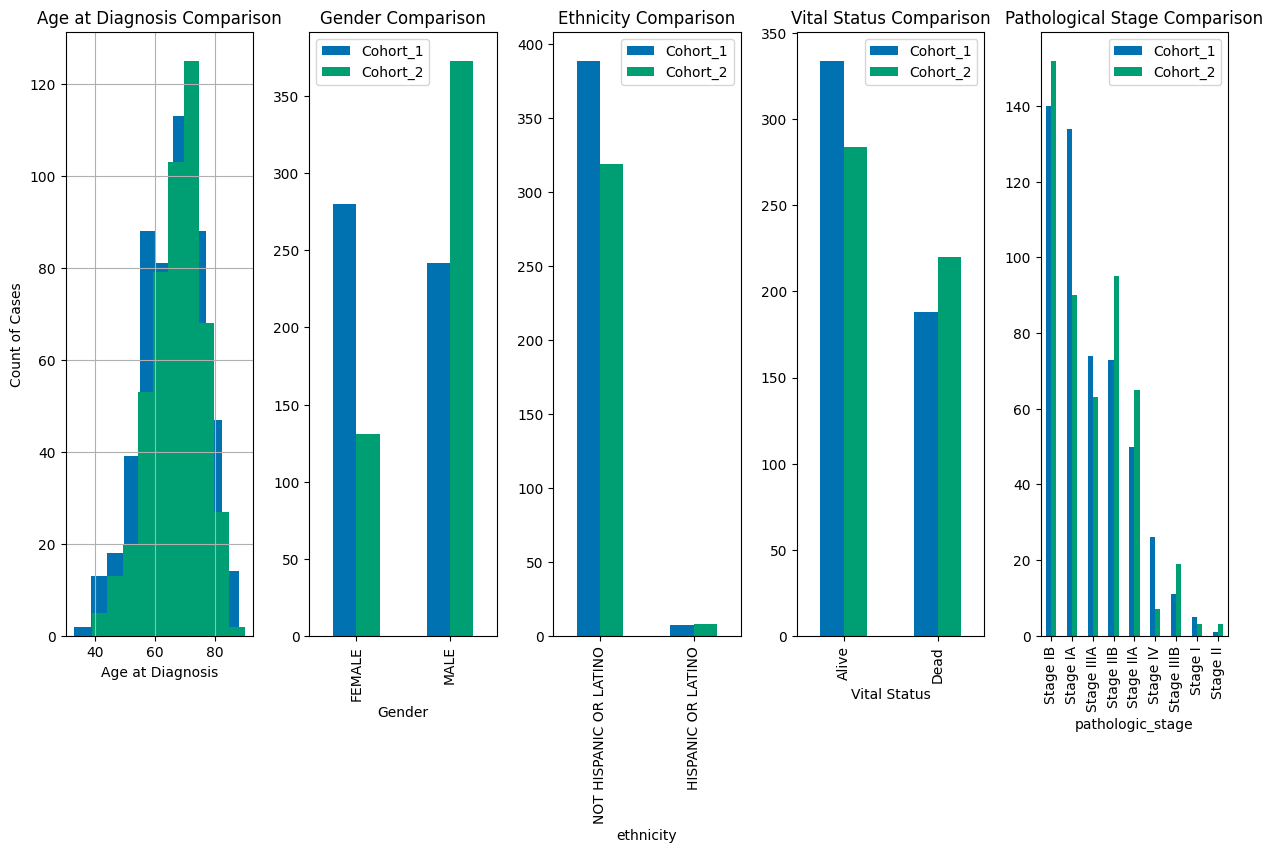

In [33]:
# Set the style of the plots
fig=plt.figure(dpi=100, figsize=(15, 8))
plt.style.use('seaborn-colorblind')

# Create the Age of Diagnosis Comparison plot
sub1 = plt.subplot(151)
for i in compare['cohort'].unique():
  df = compare['cohort'] == i
  df2 = compare.loc[df]
  df2.hist('age_at_diagnosis', ax=sub1)

sub1.set_title("Age at Diagnosis Comparison")
sub1.set_ylabel("Count of Cases")
sub1.set_xlabel("Age at Diagnosis")

# Create the Gender Comparison plot
sub2 = plt.subplot(152)
plot2 = comp_gender.plot(kind='bar', title = "Gender Comparison", ax=sub2)
plot2.set_xlabel("Gender")

# Create the Ethnicity Comparison plot
sub3 = plt.subplot(153)
plot3 = comp_ethnicity.plot(kind='bar', title = "Ethnicity Comparison", ax=sub3)
plot3.set_xlabel("ethnicity")

# Create the Vital Status Comparison plt
sub4 = plt.subplot(154)
plot4 = comp_vital_status.plot(kind="bar", title = "Vital Status Comparison", ax=sub4)
plot4.set_xlabel("Vital Status")

# Create the Pathological Stage Comparison plot
sub5 = plt.subplot(155)
plot5 = comp_pathologic_stage.plot(kind='bar', title = "Pathological Stage Comparison", ax=sub5)
plot5.set_xlabel("pathologic_stage")

# if you would like to save this plot as an image, uncomment the next two lines
# histogram_file = "file_name_here.png"
# plt.savefig(histogram_file)

# That's all folks!

So, that's it for a quick cohort comparison. If you need help or have a comment, reach out to us at feedback@isb-cgc.org



This notebook was inspired by the [ICGC Cohort Comparison Analysis tool](https://dcc.icgc.org/analysis)